# Time-dependent noise in Random Utility Models

In [255]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations

import choix

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(font_scale=1.3)

In [256]:
def AR1_empirical_mean_variances(rho, n):
    summand = (1 - rho**(n - np.arange(1, n+1) + 1))**2
    summand[0] = 0
    acc = summand.sum()
    return (
        (1-rho**2)*acc + (1-rho**n)**2
    ) / (
        (1-rho)**2
    ) / n**2
AR1_emv_vec = np.vectorize(AR1_empirical_mean_variances)
AR1_emv_vec(.9999, 10)

array(0.99967007)

In [257]:
vals = []

sigma = 1
rhos = [0.9, 0.8, 0.7, 0.6, 0.5, 0.0]
n = np.arange(1, 21)

for rho in rhos:
    
    vals.append(AR1_emv_vec(rho, n))

Text(0.5, 1.0, '$\\text{Var}(\\overline{\\varepsilon})$ with $\\varepsilon_1 \\sim \\mathcal{N}(0, 1)$')

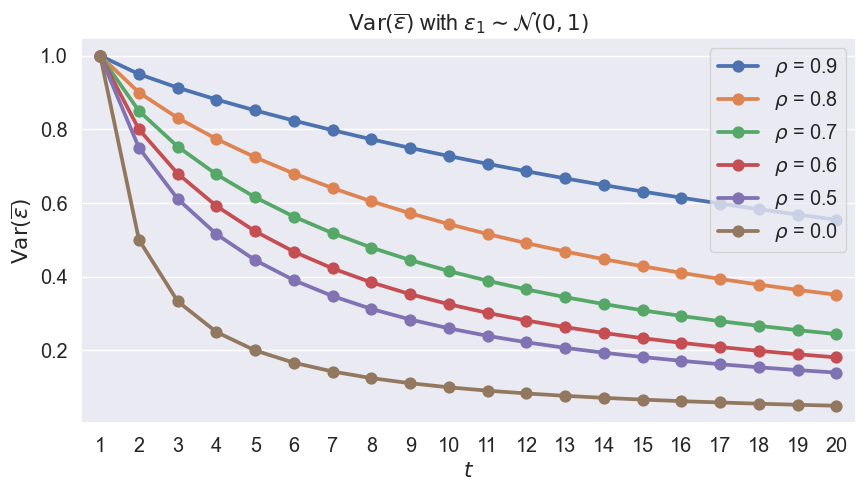

In [258]:
fig, ax = plt.subplots(figsize=(10, 5))
for val, rho in zip(vals, rhos):
    sns.pointplot(x=n, y=val, label=f"$\\rho$ = {rho}", ax=ax)

#ax.set_yscale("log")

ax.set_xlabel("$t$")
ax.set_ylabel("$\\text{Var}(\\overline{\\varepsilon})$")
ax.set_title("$\\text{Var}(\\overline{\\varepsilon})$ with $\\varepsilon_1 \\sim \\mathcal{N}(0, 1)$")

## Generation

In [259]:
def AR1_generate(n, rho):
    vals = np.zeros(n+1)
    vals[0] = np.random.normal()

    for i in range(1, n+1):
        vals[i] = rho * vals[i-1] + np.sqrt(1-rho**2)*np.random.normal()

    return vals[1:]

def AR1_many_paths(n_paths, n_steps, rho):

    paths = np.zeros((n_paths, n_steps))

    for i in range(n_paths):
        paths[i, :] = AR1_generate(n_steps, rho)
        
    return paths


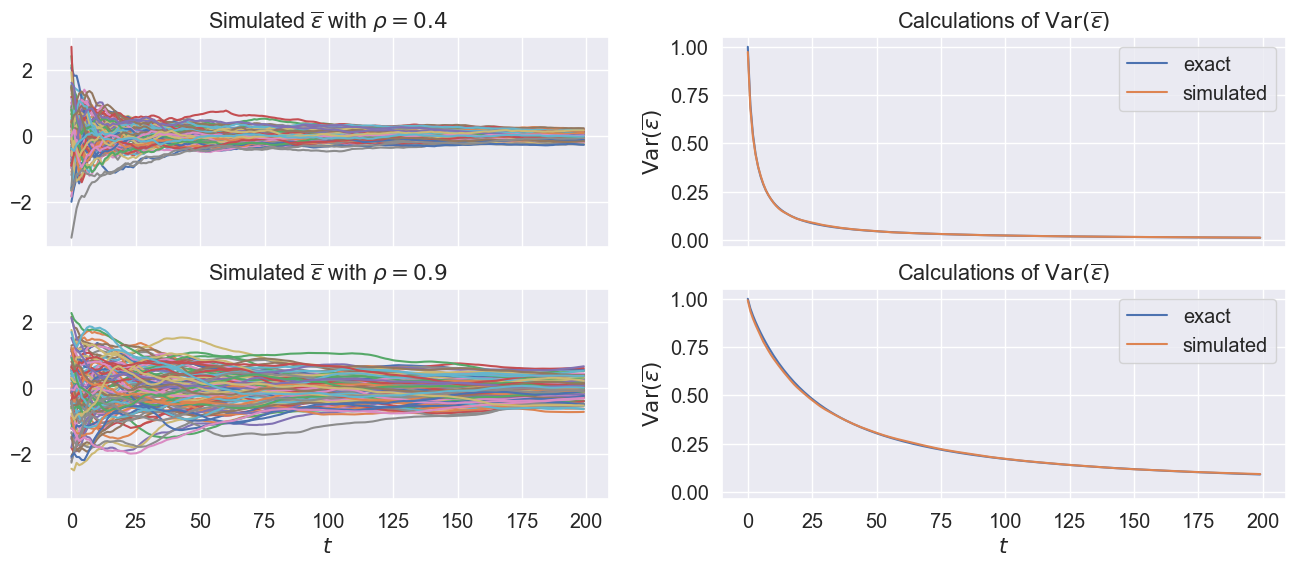

In [264]:

n_steps = 200
rhos = [0.4, 0.9]

fig, axes = plt.subplots(figsize=(16, 6), ncols=2, nrows=len(rhos), sharey="col", sharex=True)

for k, rho in enumerate(rhos):
    ax, ax2 = axes[k]
    paths = AR1_many_paths(3000, n_steps, rho)
    avgs = paths.cumsum(axis=1) / np.arange(1, n_steps+1).reshape(1, -1)
    vars_ = avgs.var(axis=0)
    for i in range(100):
        sns.lineplot(avgs[i], ax=ax)
    
    exact = AR1_emv_vec(rho, np.arange(1, n_steps+1))
    sim = vars_
    
    sns.lineplot(exact, label="exact", ax=ax2)
    sns.lineplot(sim, label="simulated", ax=ax2)
    
    ax2.set_xlabel("$t$")
    ax.set_xlabel("$t$")
    
    ax.set_title("Simulated $\\overline{\\varepsilon}$ with " + f"$\\rho = {rho}$")
    ax2.set_title("Calculations of $\\text{Var}(\\overline{\\varepsilon})$")
    ax2.set_ylabel("$\\text{Var}(\\overline{\\varepsilon})$")
    
    ax2.legend()

In [261]:
def noisy_utilities(n_items, scale, rho):

    true_utilities = scale * np.arange(0, n_items)

    n_steps = n_items*(n_items-1)//2

    noisy_utilities = np.zeros((n_items, n_steps))

    for i in range(n_items):
        noisy_utilities[i, :] = AR1_generate(n_steps, rho) + true_utilities[i]

    return noisy_utilities

def perform_comparisons(comparisons, u):
    res = []
    for k, comp in enumerate(comparisons):
        i, j = comp

        if u[i, k] < u[j, k]:
            res.append((j, i))
        else:
            res.append((i, j))
    return res

Text(0.5, 0.98, '$n=50$ and $t$ up to 100')

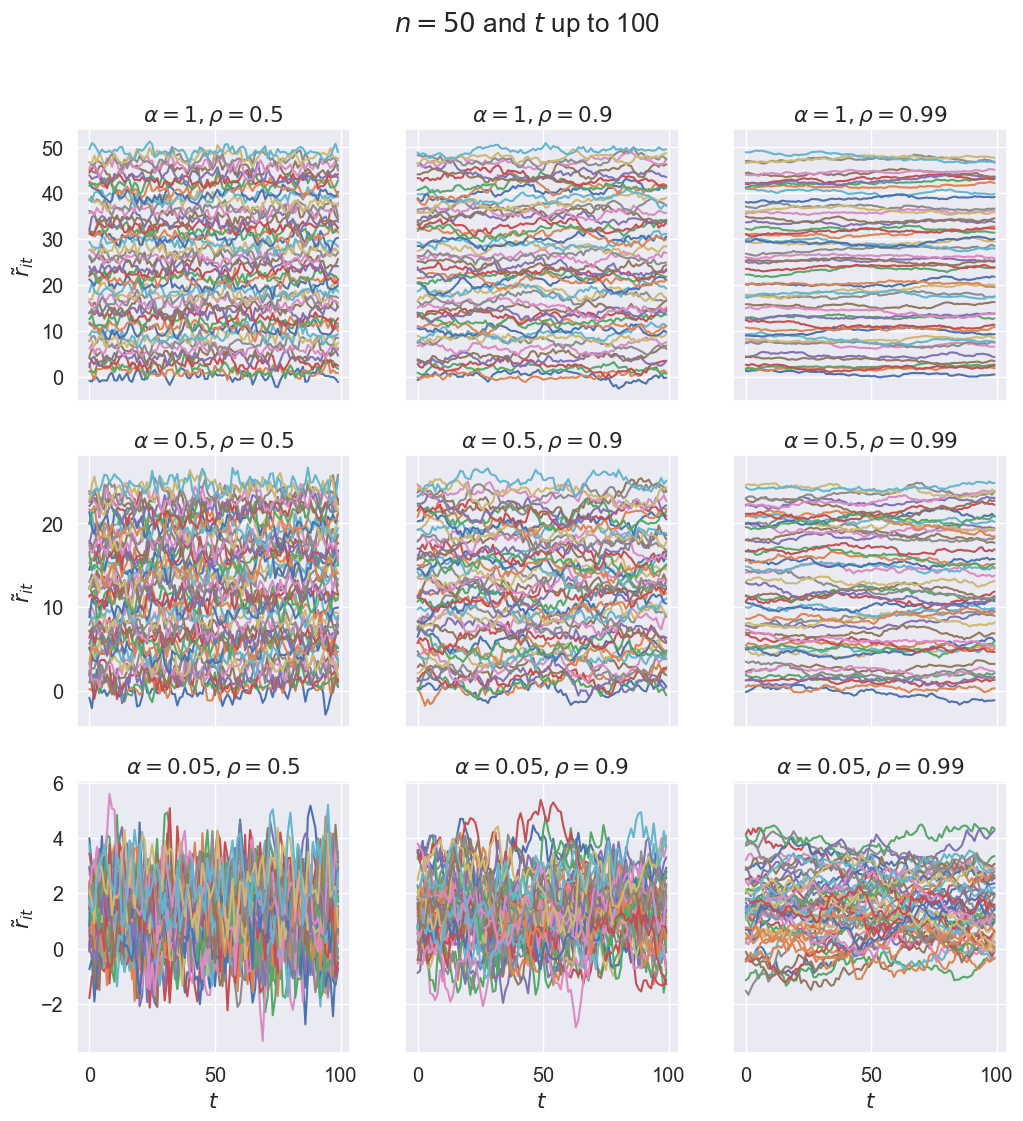

In [265]:
n_items = 50
alpha_l = [1, 0.5, 0.05]
rho_l = [0.5, 0.9, 0.99]

truncated_t = 100

fig, axes = plt.subplots(figsize=(12, 12), nrows=len(alpha_l), ncols=len(rho_l), sharex=True, sharey="row")

for i, alpha in enumerate(alpha_l):
    for j, rho in enumerate(rho_l):
        ax = axes[i, j]
        comparisons = list(combinations(range(n_items), 2))
        u = noisy_utilities(n_items, scale=alpha, rho=rho)
        
        for k in range(n_items):
            sns.lineplot(u[k][:truncated_t], ax=ax)
        
        ax.set_xlabel("$t$")
        ax.set_ylabel("$\\tilde{r}_{it}$")
        
        ax.set_title(f"$\\alpha={alpha}, \\rho={rho}$")

fig.suptitle("$n=50$ and $t$ up to 100")

In [188]:
def sum_delta_t(comparisons, n_items):
    last_seen = - np.ones(n_items)

    deltas = []

    for t, pair in enumerate(comparisons):
        i, j = pair
        if last_seen[i] >= 0:
            deltas.append(t - last_seen[i])
        if last_seen[j] >= 0:
            deltas.append(t - last_seen[j])

        last_seen[i] = last_seen[j] = t

    return sum(deltas)

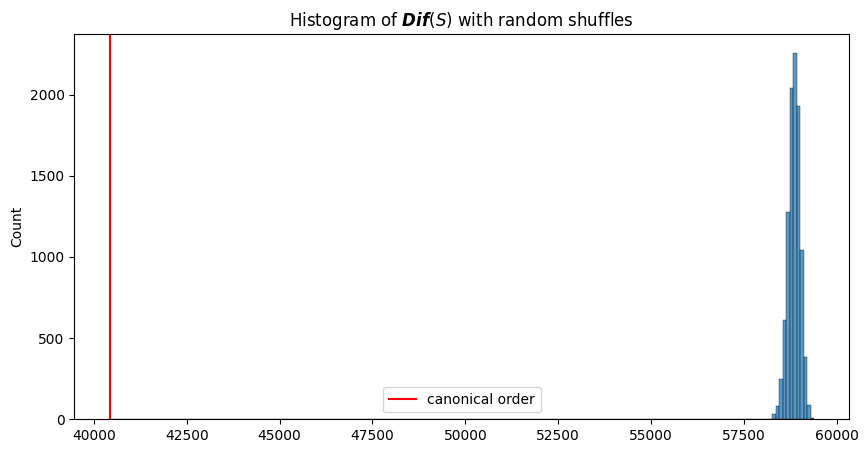

In [189]:
import random

fig, ax = plt.subplots(figsize=(10, 5))
perm = [(random.shuffle(a := comparisons.copy()), a)[1] for _ in range(10000)]
perm.append(comparisons)

sum_deltas = [sum_delta_t(p, n_items) for p in perm]
sns.histplot(sum_deltas, ax=ax)
ax.axvline(sum_deltas[-1], c="red", label="canonical order")

ax.set_title("Histogram of $\\boldsymbol{Dif}(S)$ with random shuffles")
ax.legend()

In [190]:
smallest, largest = perm[np.argmin(sum_deltas)], perm[np.argmax(sum_deltas)]

## Infer utilities

In [191]:
# ranking performance metric
# quantify item spread

from scipy.stats import spearmanr

data = perform_comparisons(perm[-1], u)

u_est = choix.lsr_pairwise(n_items, data, alpha=0.01)

spearmanr(u_est, np.arange(n_items)).statistic

np.float64(0.9605282112845137)

## experiment loop

In [270]:
rep = 1000

res = []

n_items = 50
alpha_l = [1, 0.5, 0.05]
rho_l = [0.5, 0.9, 0.99]


for i, alpha in enumerate(alpha_l):

    res.append([])
    
    for j, rho in enumerate(rho_l):

        res[-1].append([])
        
        for _ in range(rep):
            
            u = noisy_utilities(n_items, scale=alpha, rho=rho)
            s_data = perform_comparisons(smallest, u)
            l_data = perform_comparisons(largest, u)
        
            u_est_s = choix.lsr_pairwise(n_items, s_data, alpha=0.01)
            u_est_l = choix.lsr_pairwise(n_items, l_data, alpha=0.01)
        
            res[-1][-1].append((
                spearmanr(u_est_s, np.arange(n_items)).statistic,
                spearmanr(u_est_l, np.arange(n_items)).statistic
            ))

        print(i, j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


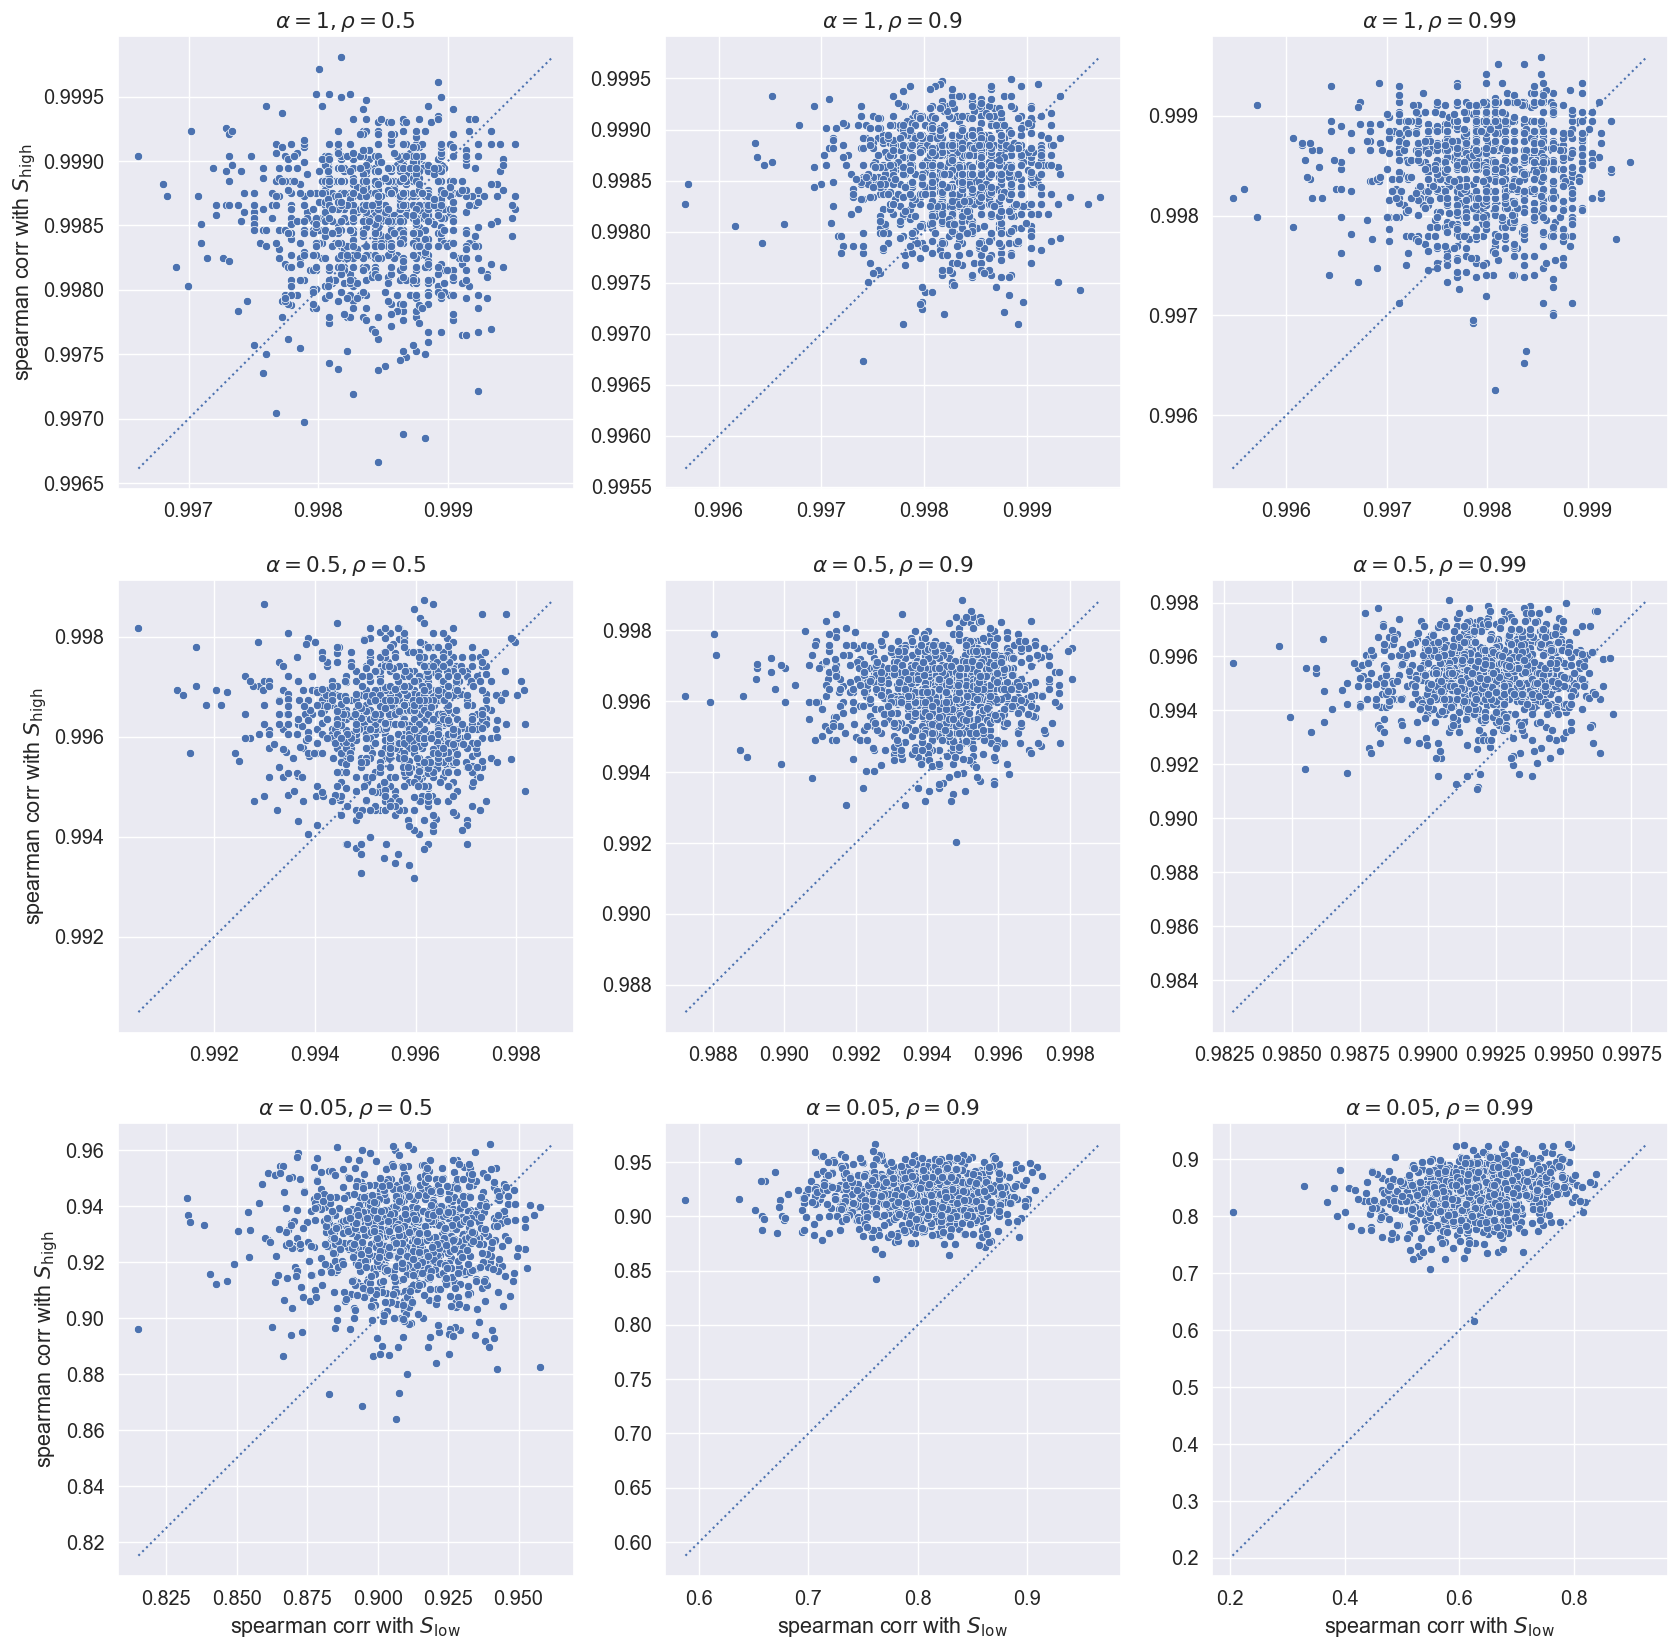

In [281]:
fig, axes = plt.subplots(figsize=(20, 20), nrows=len(alpha_l), ncols=len(rho_l))


for i, alpha in enumerate(alpha_l):
    
    for j, rho in enumerate(rho_l):
        ax = axes[i, j]

        arr = np.array(res[i][j])
        sns.scatterplot(x=arr[:, 0], y=arr[:, 1], ax=ax)
        
        ax.plot([arr.min(), arr.max()], [arr.min(), arr.max()], label="x=y", linestyle=":")
        
        if j == 0:     
            ax.set_ylabel("spearman corr with $S_\\text{high}$")
        if i == len(rho_l) - 1:
            ax.set_xlabel("spearman corr with $S_\\text{low}$")

        ax.set_title(f"$\\alpha={alpha}, \\rho={rho}$")

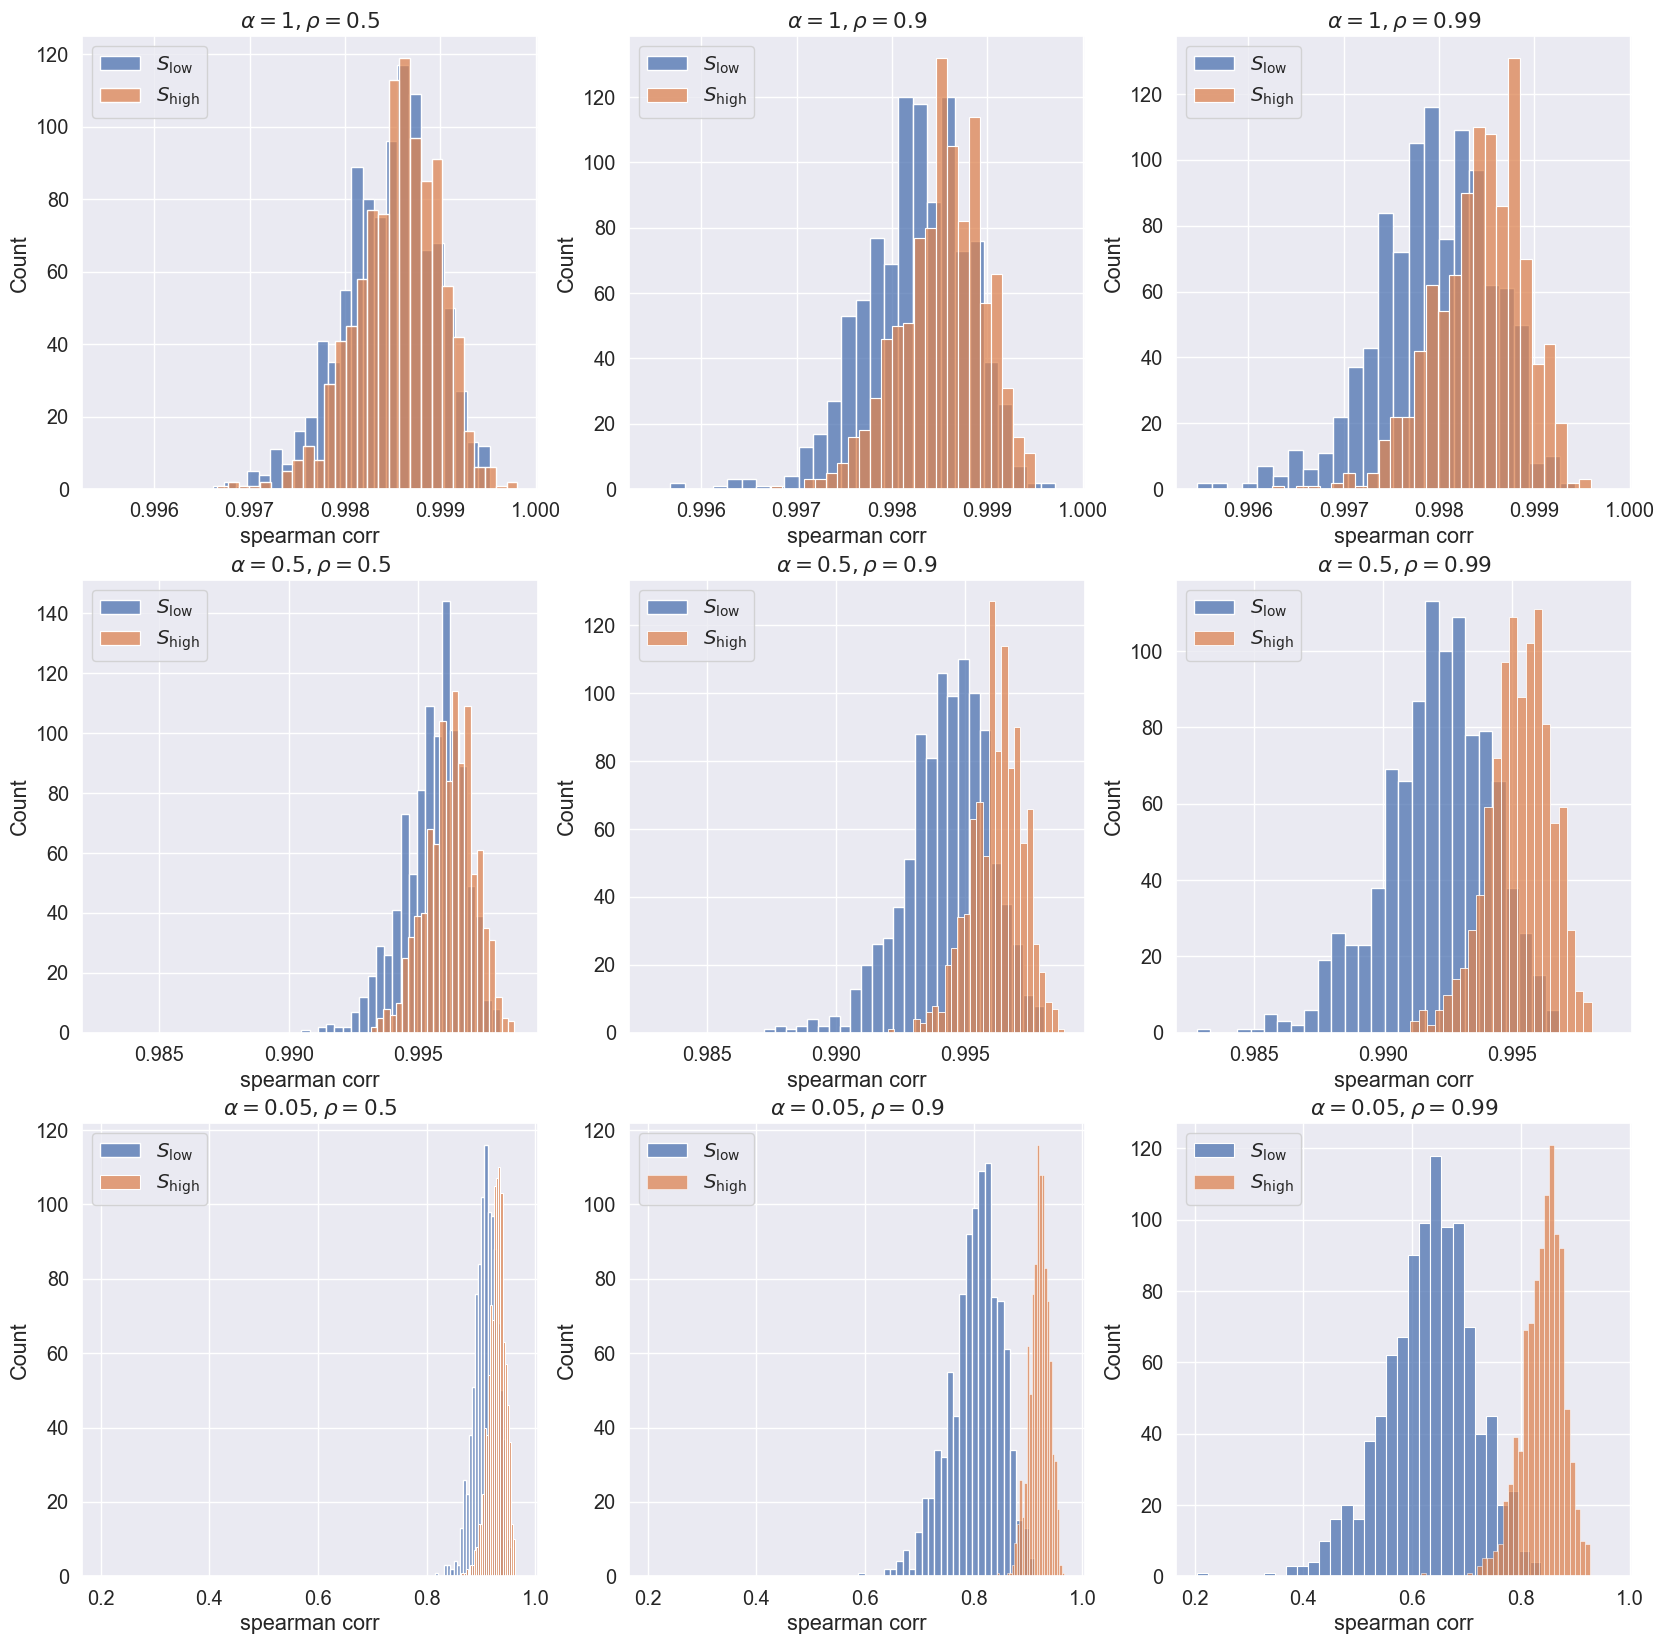

In [288]:
fig, axes = plt.subplots(figsize=(20, 20), nrows=len(alpha_l), ncols=len(rho_l), sharex="row")


for i, alpha in enumerate(alpha_l):
    
    for j, rho in enumerate(rho_l):
        ax = axes[i, j]

        arr = np.array(res[i][j])
        
        ax.set_title(f"$\\alpha={alpha}, \\rho={rho}$")
        
        sns.histplot(arr[:, 0], label="$S_\\text{low}$", ax=ax)
        sns.histplot(arr[:, 1], label="$S_\\text{high}$", ax=ax)
        ax.set_xlabel("spearman corr")
        ax.legend()